# Skin cancer detection

Dataset taken from Kaggle at [Skin Cancer ISIC](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic).

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits, load_sample_images
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer

import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasClassifier
# Import EarlyStopping and ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Create the datasets
train_images_fs, train_labels = next(train_generator)
test_images_fs, test_labels = next(test_generator)
#val_images, val_labels = next(val_generator)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [3]:
train_images_fs

array([[[[202., 179., 189.],
         [201., 180., 189.],
         [203., 181., 193.],
         ...,
         [175., 138., 145.],
         [175., 140., 146.],
         [173., 138., 145.]],

        [[203., 177., 188.],
         [203., 179., 192.],
         [204., 180., 193.],
         ...,
         [176., 141., 147.],
         [178., 138., 147.],
         [177., 137., 145.]],

        [[204., 178., 189.],
         [204., 177., 192.],
         [204., 180., 193.],
         ...,
         [176., 143., 150.],
         [176., 139., 147.],
         [177., 137., 146.]],

        ...,

        [[196., 170., 181.],
         [195., 168., 177.],
         [193., 165., 179.],
         ...,
         [171., 137., 153.],
         [170., 138., 151.],
         [169., 135., 151.]],

        [[197., 169., 181.],
         [196., 169., 178.],
         [197., 169., 183.],
         ...,
         [167., 134., 145.],
         [166., 134., 147.],
         [167., 135., 148.]],

        [[195., 167., 179.],
       

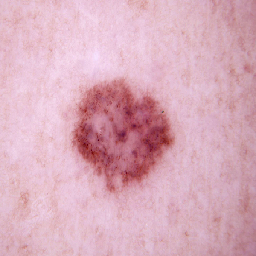

In [4]:
# Preview an image
array_to_img(train_images_fs[0])

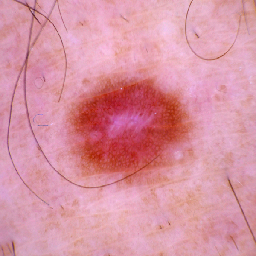

In [5]:
# Preview an image
array_to_img(test_images_fs[0])

In [6]:
train_labels.shape

(2239, 9)

In [7]:
test_labels.shape

(118, 9)

In [8]:
test_images_fs.shape

(118, 256, 256, 3)

In [9]:
train_images_fs.shape

(2239, 256, 256, 3)

In [10]:
train_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
type(train_labels)

numpy.ndarray

In [12]:
type(train_images_fs)

numpy.ndarray

In [13]:
dataframe_train=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

In [14]:
dataframe_train

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2236,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2237,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


train_generator.class_indices 

In [15]:
sums=dataframe_train.sum(axis=0)

In [16]:
sums=pd.DataFrame(sums)

In [17]:
sums

,0
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


In [18]:
sums['%'] = ((sums[0] / 2239*100).round(2).astype(str) + '%')

In [19]:
sums

,0,%
actinic_keratosis,114.0,5.09%
basal_cell_carcinoma,376.0,16.79%
dermatofibroma,95.0,4.24%
melanoma,438.0,19.56%
nevus,357.0,15.94%
pigmented_benign_keratosis,462.0,20.63%
seborrheic_keratosis,77.0,3.44%
squamous_cell_carcinoma,181.0,8.08%
vascular_lesion,139.0,6.21%


Showing in a histogram the distribution of the different images in the train set

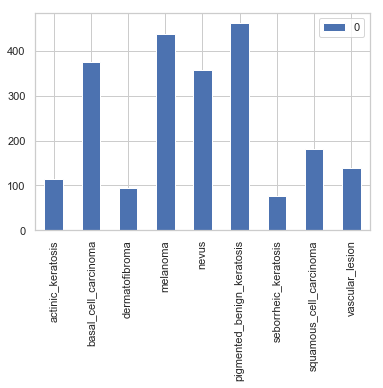

In [20]:
#Change this into seaborn to make it even cooler
sums.plot(kind='bar');

Melanoma is cancer 438
acitinic keartosis is pre cancer 114
basal cell is cancer 376
squamous cell cancer 181


dermatofibroma bening 95
benign keratosis 462
nevus bening 357
seborrheic bening 77 
vascular lesion bening 139

And for the test:

In [21]:
dataframe_test=pd.DataFrame(test_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])
sums_test=dataframe_test.sum(axis=0)
sums_test=pd.DataFrame(sums_test)

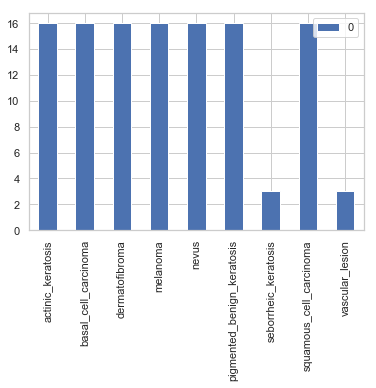

In [22]:
#Change this into seaborn to make it even cooler
sums_test.plot(kind='bar');

In [23]:
sums_test['%'] = ((sums_test[0] / 118*100).round(2).astype(str) + '%')

In [24]:
sums_test

,0,%
actinic_keratosis,16.0,13.56%
basal_cell_carcinoma,16.0,13.56%
dermatofibroma,16.0,13.56%
melanoma,16.0,13.56%
nevus,16.0,13.56%
pigmented_benign_keratosis,16.0,13.56%
seborrheic_keratosis,3.0,2.54%
squamous_cell_carcinoma,16.0,13.56%
vascular_lesion,3.0,2.54%


Melanoma is cancer 16
acitinic keartosis is pre cancer 16
basal cell is cancer 16
squamous cell cancer 16


dermatofibroma bening 16
benign keratosis 16
nevus bening 16
seborrheic bening 3 
vascular lesion bening 3

Ok so malignant is 54% and bening is 46%.
Still a good balance between the two classes, I wouldn't mess with that.
BUT it could be a problem because the distribution between the classes is different, this might be what could bring a problem to the model that hasn't "learnt" how to identify specific classes, that are less present in the train and much mor en the test.
Namely acitinic keartosis and dermatofibroma.
List this as a possible cause of lower performance.

> Here also definitely preview one image per class and explain a bit about each class.

## Preprocessing

We are going to reimport our images with a lower resolution, since we want the models to be faster especially since we want to try a lot of them, then finally when we will run the final model and test it on the test we will use our best tuned model, retraining it on the full size images.

In [25]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img32, train_lab = next(train_gen)
test_img32, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [26]:
# Explore your dataset again
m_train = train_img32.shape[0]
num_px = train_img32.shape[1]
m_test = test_img32.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img32.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img32.shape))
print ("test_labels shape: " + str(test_lab.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 32, 32, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 32, 32, 3)
test_labels shape: (118, 9)


In [27]:
train_y = np.reshape(train_lab[:,0], (2239,1))

Building some functions that will help us visualize and compare the different models:

In [28]:
def visualize_training_results(results):
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Creating the empty dataframe where we will store the results:

In [29]:
# create an Empty DataFrame object
df = pd.DataFrame()

Creating two functions to preview the results of our models.
With these functions we will display the evolution of accuracy and loss in our model, during the different epochs.
Below that we will see also the values of accuracy and loss and over time we will build a learning curve, adding the result of each previous model and the current one, to see if our model is improving.
The two different funcitons are plotting this last "lerning curve" as either a line plot or a scatter plot.

In [30]:
def model_results(results, model_name, df):
    visualize_training_results(results)
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': [round(results.history['acc'][-1],5)] ,
        'accuracy validation': [round(results.history['val_acc'][-1],5 )],
        'loss train': [round(results.history['loss'][-1],5)],
        'loss validation': [round(results.history['val_loss'][-1],5)]})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

In [31]:
def model_results_scat(results, model_name, df):
    visualize_training_results(results)
    df1 = pd.DataFrame({'Name': [model_name],
       'accuracy train': [round(results.history['acc'][-1],5)] ,
       'accuracy validation': [round(results.history['val_acc'][-1],5 )],
       'loss train': [round(results.history['loss'][-1],5)],
       'loss validation': [round(results.history['val_loss'][-1],5)]})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.scatter(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.scatter(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.scatter(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.scatter(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

We will create later a function to create a model. But since we want our model to be well structured, it doesn't make sense to do so for a naive model, that needs to be instead as skimmed down and simple as possible.

In [32]:
"""And let us create another function to generate models.
With this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.
We will also set most of these parameters as default, except for input shape, to make the execution of the function not too heavy."""

'And let us create another function to generate models.\nWith this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.\nWe will also set most of these parameters as default, except for input shape, to make the execution of the function not too heavy.'

In [33]:
"""def create_model(input_shape, activation='relu', 
                 loss='sparse_categorical_crossentropy', 
                optimizer='rmsprop',metrics=['acc'],
                 neur1=10, neur2=32, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model"""

"def create_model(input_shape, activation='relu', \n                 loss='sparse_categorical_crossentropy', \n                optimizer='rmsprop',metrics=['acc'],\n                 neur1=10, neur2=32, pool=(2,2)):\n # create model\n    model = models.Sequential()\n    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,\n                        input_shape=input_shape))\n    model.add(layers.MaxPooling2D(pool))\n    \n    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))\n    model.add(layers.MaxPooling2D(pool))\n\n    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))\n    model.add(layers.MaxPooling2D(pool))\n\n    model.add(layers.Flatten())\n    model.add(layers.Dense(32, activation=activation))\n    model.add(layers.Dense(9, activation='softmax'))\n\n# Compile model\n    model.compile(loss=loss,\n              optimizer=optimizer,\n              metrics=metrics)\n    return model"

And one more function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too.

In [34]:
def fit_model(model, train, y, epo=15, batch=15, val_split=0.3, verbose=0):
    results = model.fit(train, y, epochs=epo, batch_size=batch, 
                        validation_split=val_split, verbose=verbose)
    return results

In [35]:
#visualize_training_results(history)

### Trying to pick a Naive model

Trying with a simple model:

In [36]:
"""model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])"""

"model = models.Sequential()\nmodel.add(layers.Conv2D(10, (3, 3), activation='relu',\n                        input_shape=(32 ,32,  3)))\nmodel.add(layers.MaxPooling2D((2, 2)))\n\nmodel.add(layers.Flatten())\nmodel.add(layers.Dense(32, activation='relu'))\nmodel.add(layers.Dense(9, activation='softmax'))\n\nmodel.compile(loss='sparse_categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['acc'])"

And doing only 10 epochs:

In [37]:
#history1 = fit_model(model, train_img32,train_y)

Let us visualize the results of this first model:
The bottom two graphs will make sense only later on since we are building a learning curve, to compare the different models' performance.

In [38]:
#df=model_results(history1, '32x32 1st model', df)
#df

Another attempt: all the previous parameters but making the last dense layer smaller.

In [39]:
"""model2 = models.Sequential()
model2.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(9, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])"""

"model2 = models.Sequential()\nmodel2.add(layers.Conv2D(10, (3, 3), activation='relu',\n                        input_shape=(32 ,32,  3)))\nmodel2.add(layers.MaxPooling2D((2, 2)))\n\nmodel2.add(layers.Flatten())\nmodel2.add(layers.Dense(10, activation='relu'))\nmodel2.add(layers.Dense(9, activation='softmax'))\n\nmodel2.compile(loss='sparse_categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['acc'])"

In [40]:
#history3 = fit_model(model2,train_img32,train_y)

In [41]:
#df=model_results(history3, '32x32 3rd model, < nrns last layer', df)
#df

#### Even less Neurons:

In [42]:
"""model3 = models.Sequential()
model3.add(layers.Conv2D(5, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(9, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])"""

"model3 = models.Sequential()\nmodel3.add(layers.Conv2D(5, (3, 3), activation='relu',\n                        input_shape=(32 ,32,  3)))\nmodel3.add(layers.MaxPooling2D((2, 2)))\n\nmodel3.add(layers.Flatten())\nmodel3.add(layers.Dense(5, activation='relu'))\nmodel3.add(layers.Dense(9, activation='softmax'))\n\nmodel3.compile(loss='sparse_categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['acc'])"

In [43]:
#history4 = fit_model(model3, train_img32,
#                    train_y)

In [44]:
#df=model_results(history4, '32x32 4th model, < neurons', df)
#df

#### Less resolution images.

In [45]:
# Directory path
train_data_dir = 'dataskin/Train'
#test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
#test_gen= ImageDataGenerator().flow_from_directory(
#        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img8, train_lab = next(train_gen)
#test_img, test_lab = next(test_gen)

Found 2239 images belonging to 9 classes.


In [46]:
train_img8.shape

(2239, 8, 8, 3)

In [47]:
train_y = np.reshape(train_lab[:,0], (2239,1))
#test_y = np.reshape(test_lab[:,0], (118,1))

In [48]:
model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(8 ,8,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [49]:
history = fit_model(model, train_img8,
                    train_y, epo=10, batch=10)

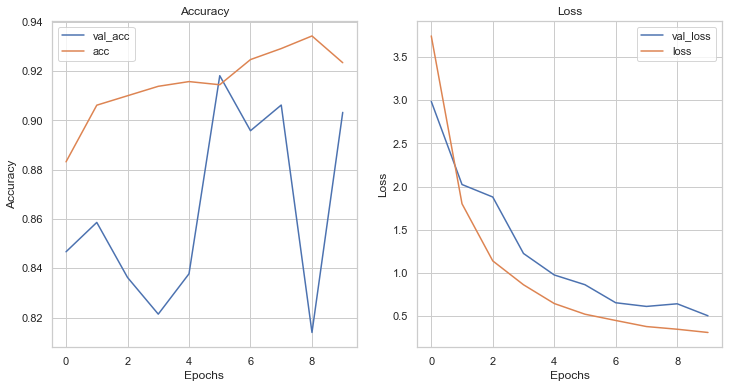

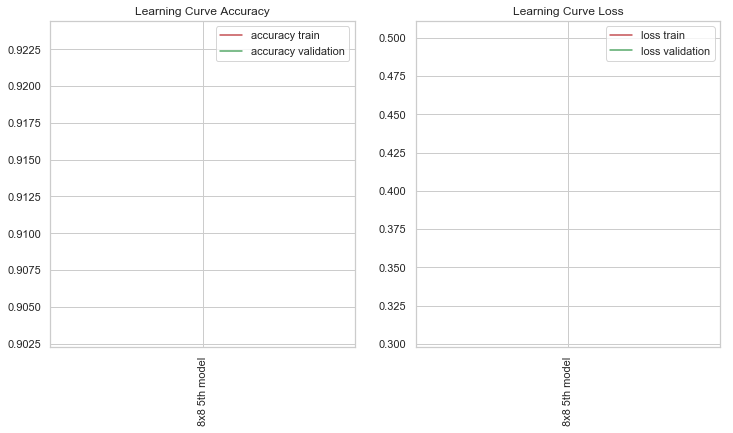

In [50]:
df=model_results(history, '8x8 5th model', df)

The good news is that even if the results change a lot in the first part where I do regualr NN, every time I run the code, they don't change so radically with the CNN.
I will keep track a bit but overall it seems like I can stop worrying about reproducibe results, if I use CNN right away.

## Starting to improve our model:

Taking from the german signs notebook

Nope. It's in AWS Sagemaker. But I can look back at it and use either a simple pipeline for loading and changing the size of the images, or for images augmentation to balance the classes of the different skin anomalies.
<br>A simple pipeline can even be "load, normalize, augment".

#### To improve our model we will take several steps:
   - normalize the data 
   - increase image resolution
   - add more epochs
   - add more layers
   - increase the batch size
   - change activation function and optimization
    
After we have done all this we will select the best performing model and we will also group up into 2 classes, cancerous and benign growth too.
<br>Maybe I should do that now actually.
<br>No I will do it after this first selection so I can say I have a good model to predict which of the 9 classes with this much accuracy.
<br>And then introduce the concept of two classes and decreasing recall.
<br>After that anyhow, do another round of tuning for the model, this time using:
 - drop out layers
 - regularization
 - normalization
 - data augmentation
 - balancing classes with data augmentation
 

### Improving the model with 9 classes:

Restart with an empty dataframe because while before we were looking for the lowest performance model now we are looking to improve it.

In [51]:
df = pd.DataFrame()

Let us start by visualizing again the results from what we picked to be our naive model:

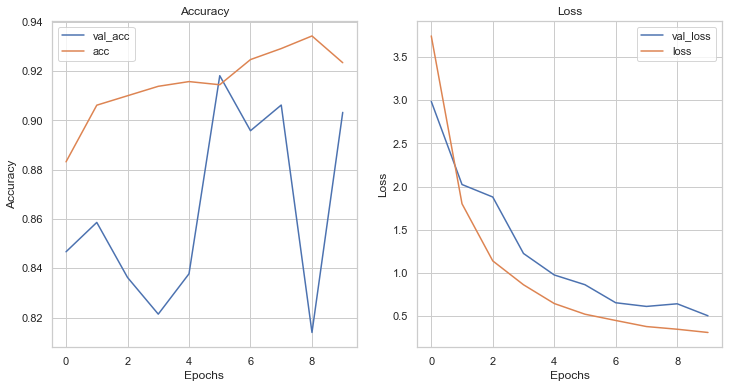

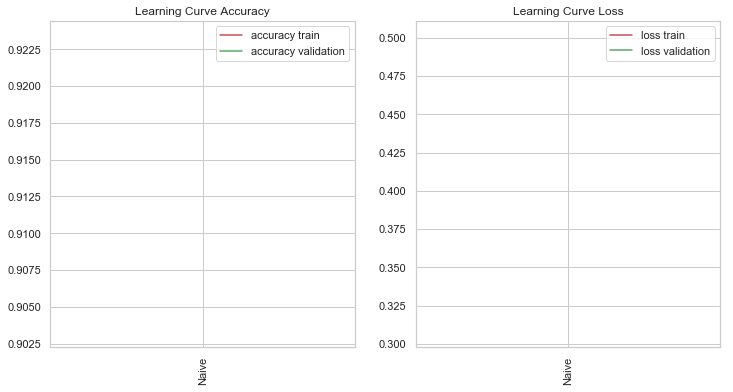

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.92342,0.90327,0.30768,0.50128


In [52]:
df=model_results(history, 'Naive', df)
df

#### Normalize the data:

In [53]:
train_img8[0][1]

array([[127., 113., 100.],
       [140., 133., 123.],
       [154., 153., 149.],
       [151., 141., 129.],
       [167., 173., 173.],
       [159., 160., 152.],
       [150., 146., 135.],
       [141., 142., 134.]], dtype=float32)

As we can see the RGB values of each pixel are not scaled, we are going to scale their value between 0 and 1 by dividing each pixel value by 225.
To standardize the pixel values:

In [54]:
train_img8 /= 255.

In [55]:
train_img8[0][1]

array([[0.49803922, 0.44313726, 0.39215687],
       [0.54901963, 0.52156866, 0.48235294],
       [0.6039216 , 0.6       , 0.58431375],
       [0.5921569 , 0.5529412 , 0.5058824 ],
       [0.654902  , 0.6784314 , 0.6784314 ],
       [0.62352943, 0.627451  , 0.59607846],
       [0.5882353 , 0.57254905, 0.5294118 ],
       [0.5529412 , 0.5568628 , 0.5254902 ]], dtype=float32)

In [57]:
history52 = fit_model(model, train_img8,train_y)

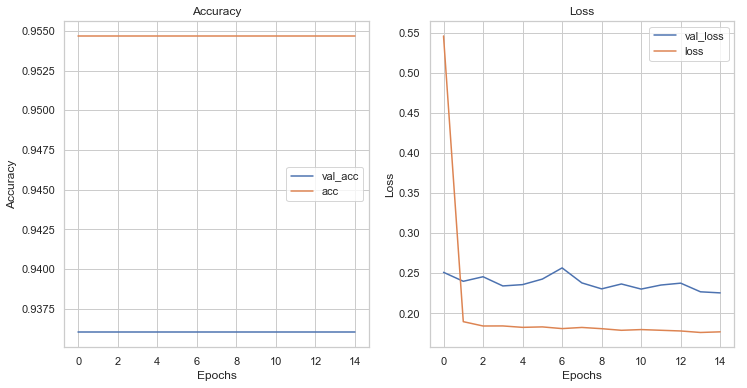

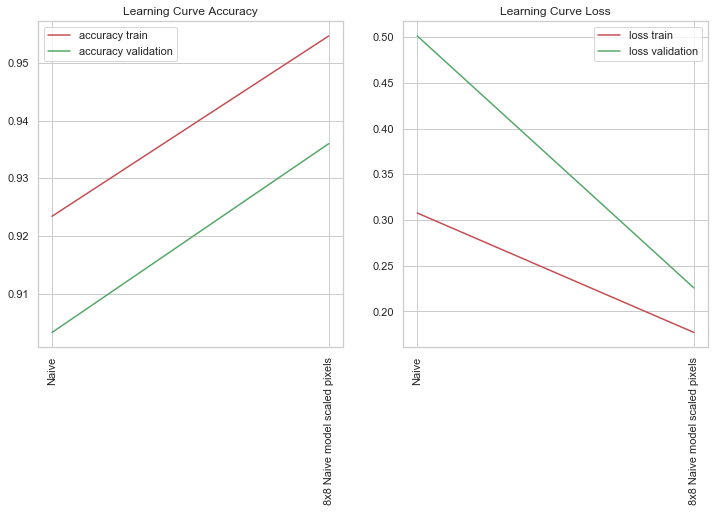

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.92342,0.90327,0.30768,0.50128
0,8x8 Naive model scaled pixels,0.95469,0.93601,0.17704,0.22570


In [58]:
df=model_results(history52, '8x8 Naive model scaled pixels', df)
df

#### Adding more layers:

Let us move on from the basic naive model to a more structured one with more layers.
We will define it with a function that will allow us to also tweak other parameters, which is what we will do to keep tuning our model.
With this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.
We will also set most of these parameters as default, except for input shape, to make the execution of the function not too heavy.

In [59]:
def create_model(input_shape=(64, 64, 3), activation='relu', 
                 loss='sparse_categorical_crossentropy', 
                optimizer='rmsprop',metrics=['acc'] , 
                 neur1=10, neur2=20, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model

In [60]:
model_a=create_model(input_shape=(32,32,3))

In [61]:
history1 = fit_model(model_a, train_img32,train_y)

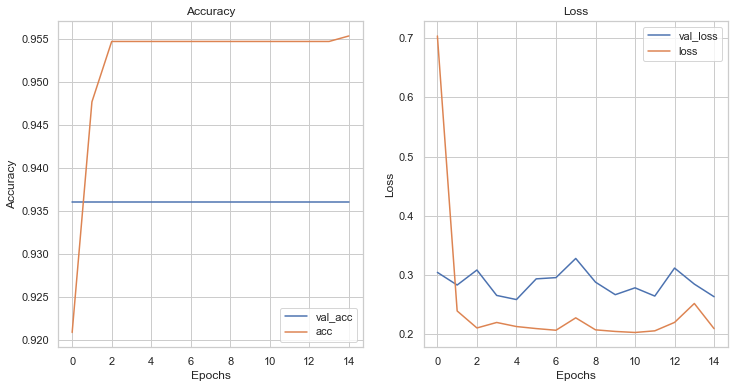

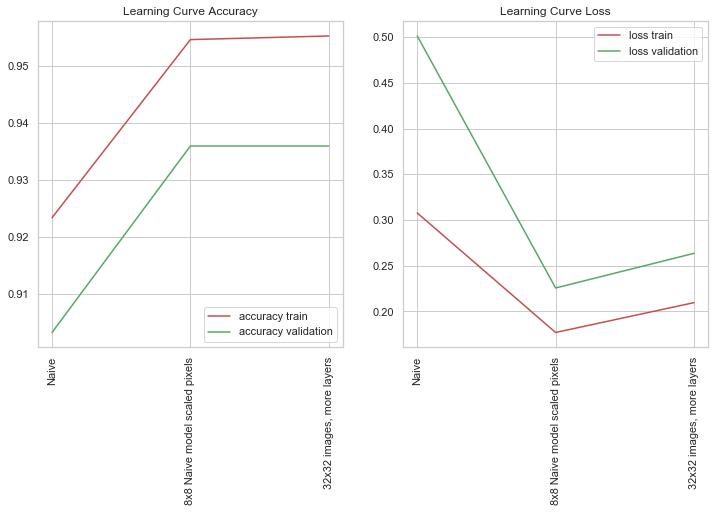

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.92342,0.90327,0.30768,0.50128
0,8x8 Naive model scaled pixels,0.95469,0.93601,0.17704,0.22570
0,"32x32 images, more layers",0.95533,0.93601,0.20966,0.26357


In [62]:
df=model_results(history1, '32x32 images, more layers', df)
df

#### Increasing Image resolution:
Importing images with 64x64 image resolution.

In [63]:
# Directory path
train_data_dir = 'dataskin/Train'
#test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Create the datasets
train_img64, train_lab = next(train_gen)
test_img64, test_lab = next(test_gen)

#normalizing again
train_img64 /= 255.
test_img64 /= 255.

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [64]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [65]:
# No need to specify input shape, since the default is 64x64
model_b=create_model()

In [66]:
history2 = fit_model(model_b, train_img64, train_y)

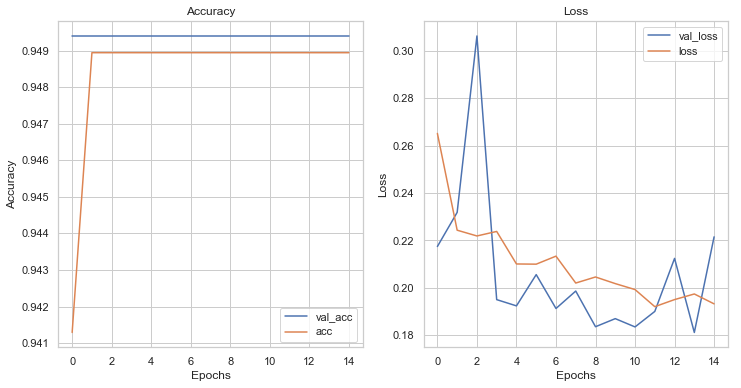

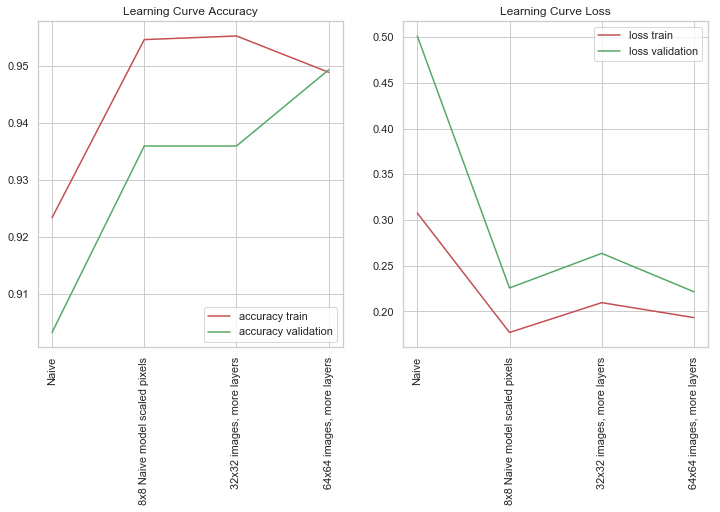

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.92342,0.90327,0.30768,0.50128
0,8x8 Naive model scaled pixels,0.95469,0.93601,0.17704,0.22570
0,"32x32 images, more layers",0.95533,0.93601,0.20966,0.26357
0,"64x64 images, more layers",0.94895,0.94940,0.19327,0.22153


In [67]:
df=model_results(history2, '64x64 images, more layers', df)
df

We tried also importing the images in their full size, and training the model on those but there was no substantial improvement in the performance, therefore we decided it was not worth the extra long computational time, and we did not include it.

#### Increasing number of epochs:
Keeping the same model, but we will do it with images sizes 64 to reduce running time.

In [68]:
history4=fit_model(model_b, train_img64, train_y, epo=30)

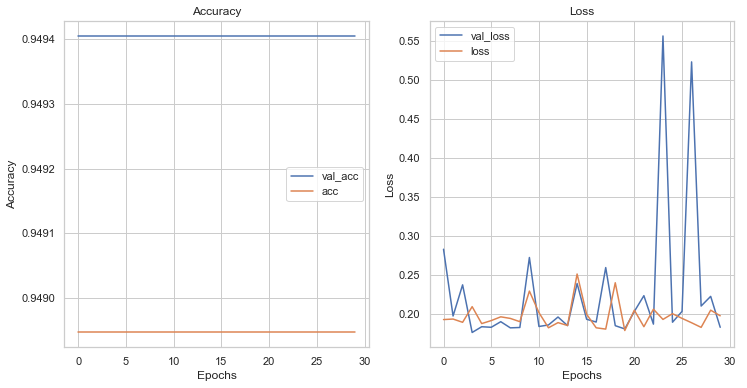

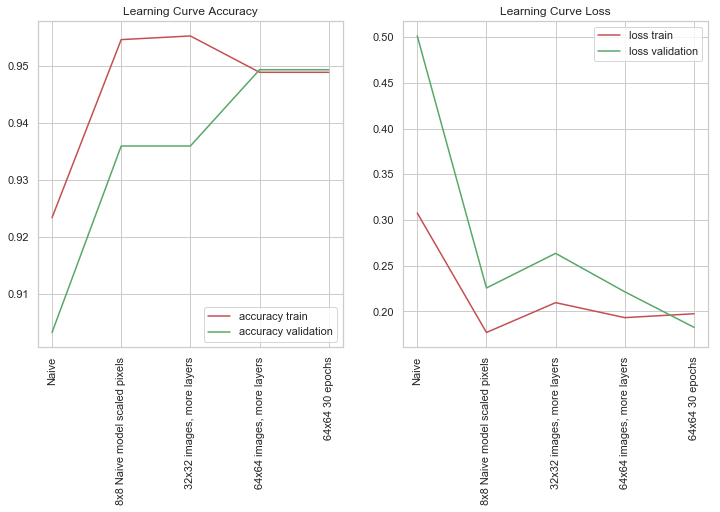

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.92342,0.90327,0.30768,0.50128
0,8x8 Naive model scaled pixels,0.95469,0.93601,0.17704,0.22570
0,"32x32 images, more layers",0.95533,0.93601,0.20966,0.26357
0,"64x64 images, more layers",0.94895,0.94940,0.19327,0.22153
0,64x64 30 epochs,0.94895,0.94940,0.19751,0.18272


In [69]:
df=model_results(history4, '64x64 30 epochs', df)
df

#### Increase the batch size: 50

In [70]:
history5=fit_model(model_b, train_img64, train_y, epo=30, batch=50)

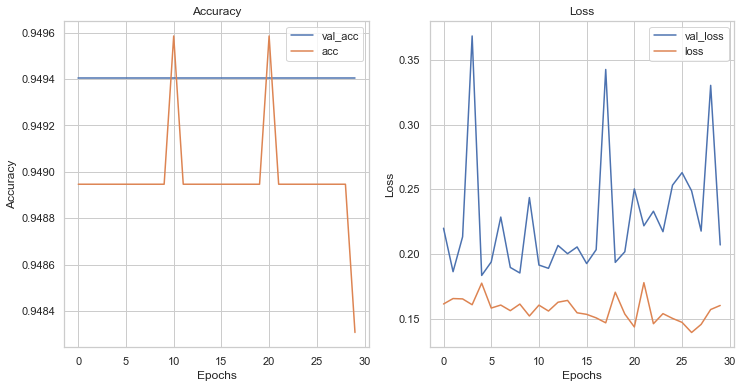

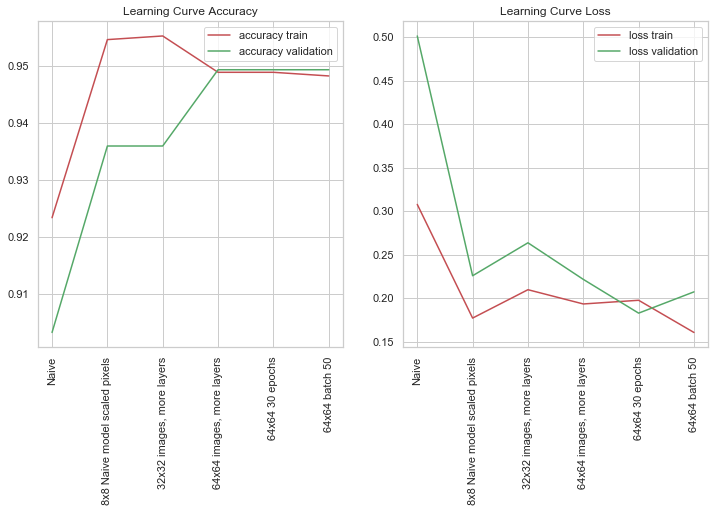

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.92342,0.90327,0.30768,0.50128
0,8x8 Naive model scaled pixels,0.95469,0.93601,0.17704,0.22570
0,"32x32 images, more layers",0.95533,0.93601,0.20966,0.26357
0,"64x64 images, more layers",0.94895,0.94940,0.19327,0.22153
0,64x64 30 epochs,0.94895,0.94940,0.19751,0.18272
0,64x64 batch 50,0.94831,0.94940,0.16050,0.20717


In [71]:
df=model_results(history5, '64x64 batch 50', df)
df

The truth is that just getting one result for each of these attempts doesn't really tell us too much about the improvement or not of our model, because of the randomness of the results.
What would be more appropriate is for each change we do (in the size of the images, the number of epochs, the batch size) to try a few different values to be able to really get a sense of in which direction our model is moving with that change.
This would be very time consuming to do by hand, so the next step we are goign to take is building a grid search for these parameteres to get a better answer in terms of which ones are the optimal charateristic of our model, which gives us the best accuracy in determining the classification of the skin anomaly.

### Grid Search batch size and epochs:

Grid search is a model hyperparameter optimization technique.
In scikit learn this is a class, and when running a search with this class, we must input a dictionary of hyperparameters to evaluate in the param_grid argument. 
This dictionary contains the model parameter name and an array of values to try.

The GridSearchCV essentially builds and then evaluates one model for each combination of parameters. 
To evaluate each individual model, a 3-fold cross validation is used.

Once we  find out from the GridSearch what are the best parameteres we can use those (running just one single model) with higher resolution images.

Since GridSearch takes a long time to run, for this one and also the following ones we included the code but commented it out, saving the parameteres that were identified by the search (see below) so that the search doesn't need to be re run every time.

In [72]:
# Use scikit-learn to grid search the batch size and epochs
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model())
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpzbbn9ipr/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp43_lnrr6/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpb9zqdrks/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp69vmv7jg/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpcq1nnqd9/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpk7wjxu7v/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpzmvfw97x/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp1yk26kx7/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpg95t9xvk/assets
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp5_k7wkec/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpy39qml6d/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp544s5e8v/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmppgw1314a/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpao3r911m/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpy5gwpv6_/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp461imvgj/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp46le5k82/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpo_mo9zkf/assets
INFO:tensorflow:Ass

In [73]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.949084 using {'batch_size': 10, 'epochs': 10}
0.949084 (0.000032) with: {'batch_size': 10, 'epochs': 10}
0.946405 (0.002189) with: {'batch_size': 10, 'epochs': 50}
0.944622 (0.005359) with: {'batch_size': 10, 'epochs': 100}
0.949084 (0.000032) with: {'batch_size': 20, 'epochs': 10}
0.937030 (0.007615) with: {'batch_size': 20, 'epochs': 50}
0.924070 (0.012842) with: {'batch_size': 20, 'epochs': 100}
0.949084 (0.000032) with: {'batch_size': 40, 'epochs': 10}
0.942382 (0.006119) with: {'batch_size': 40, 'epochs': 50}
0.909775 (0.013544) with: {'batch_size': 40, 'epochs': 100}
0.949084 (0.000032) with: {'batch_size': 60, 'epochs': 10}
0.937475 (0.005585) with: {'batch_size': 60, 'epochs': 50}
0.929433 (0.007119) with: {'batch_size': 60, 'epochs': 100}
0.949084 (0.000032) with: {'batch_size': 80, 'epochs': 10}
0.941940 (0.002489) with: {'batch_size': 80, 'epochs': 50}
0.927195 (0.007957) with: {'batch_size': 80, 'epochs': 100}
0.949084 (0.000032) with: {'batch_size': 100, 'epochs': 

At least these results are not all the same for the different epochs and batches. They are all different the best one is really 10 and 10

In [74]:
best_params=grid_result.best_params_
best_params

{'batch_size': 10, 'epochs': 10}

In [75]:
best_batch=best_params['batch_size']

In [76]:
#best_batch=10

In [77]:
best_epochs=best_params['epochs']

In [78]:
#best_epochs=10

Now we can run again a model with the higher resolution images, using the best parameters we obtained from the grid search.

In [79]:
history6 = fit_model(model_b, train_img64, train_y,
                    epo=best_epochs,
                    batch=best_batch)

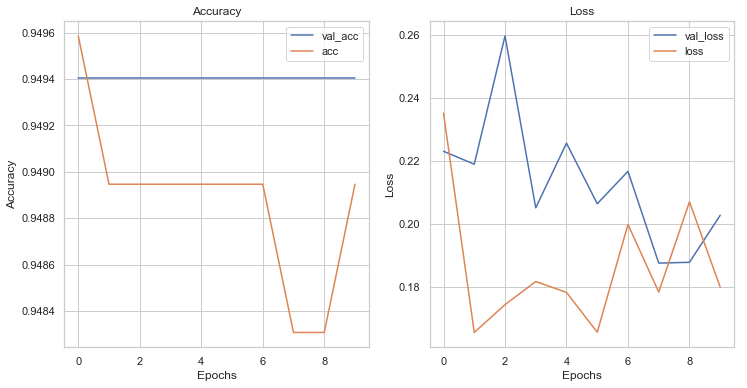

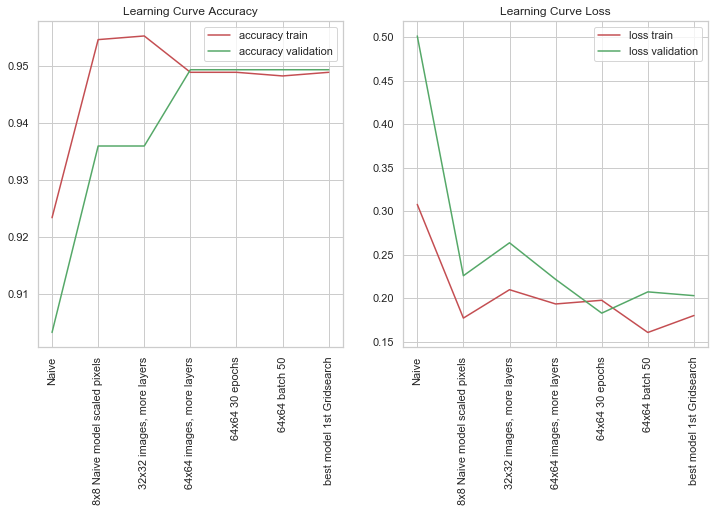

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.92342,0.90327,0.30768,0.50128
0,8x8 Naive model scaled pixels,0.95469,0.93601,0.17704,0.22570
0,"32x32 images, more layers",0.95533,0.93601,0.20966,0.26357
0,"64x64 images, more layers",0.94895,0.94940,0.19327,0.22153
0,64x64 30 epochs,0.94895,0.94940,0.19751,0.18272
0,64x64 batch 50,0.94831,0.94940,0.16050,0.20717
0,best model 1st Gridsearch,0.94895,0.94940,0.18000,0.20282


In [80]:
df=model_results(history6, 'best model 1st Gridsearch', df)
df

### Grid Search Optimization Algorithm:

We can run again a GridSearch, but this time instead of trying different numbers of epochs and batch sizes, we will try different optimization algorithms. Here is a lists of them, and as we can see from the number of options, GridSearch is a good idea to shorten the time in trying all the different possible combinations:

- 'SGD'
- 'RMSprop'
- 'Adagrad'
- 'Adadelta'
- 'Adam' 
- 'Adamax' 
- 'Nadam'

> two words here on SGD and Adam

We already have the function to create the model, and the X and Y we set before are the same. We just need to change the grid for the search of the parameters.

In [81]:
# create model
model = KerasClassifier(model=create_model(), 
                        loss="sparse_categorical_crossentropy", 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpjjy06esf/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp8ilamy52/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp0hjkvjl9/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpuxjsnee3/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmpqor48fp6/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp4id_ddky/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp1xbb5vq8/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp9fl678zn/assets
INFO:tensorflow:Assets written to: ram:///var/folders/kv/4tc8111n0hd766vkv_ly4pw80000gn/T/tmp9gbc1zm_/assets
INFO:tensorflow:Ass

In [82]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.949084 using {'optimizer': 'SGD'}
0.949084 (0.000032) with: {'optimizer': 'SGD'}
0.949084 (0.000032) with: {'optimizer': 'RMSprop'}
0.949084 (0.000032) with: {'optimizer': 'Adagrad'}
0.949084 (0.000032) with: {'optimizer': 'Adadelta'}
0.949084 (0.000032) with: {'optimizer': 'Adam'}
0.949084 (0.000032) with: {'optimizer': 'Adamax'}
0.949084 (0.000032) with: {'optimizer': 'Nadam'}


In [83]:
best_params=grid_result.best_params_
best_params

{'optimizer': 'SGD'}

In [84]:
best_opti=best_params['optimizer']
best_opti

'SGD'

In [ ]:
### Just for now let me add this so we don't have to redo the search
#best_opti='sgd'

Creating a new model with the selected optimizer algorithm:

In [ ]:
model_d=create_model(optimizer=best_opti)

In [ ]:
history7 = fit_model(model_d, train_img64, train_y,
                    epo=best_epochs,
                    batch=best_batch)

In [ ]:
df=model_results(history7, 'best model Gridsearch optimization', df)
df

### Grid Search Learning Rate and Momentum

In [ ]:
"""# create model
model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", 
                        optimizer="SGD", epochs=10, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)"""

In [ ]:
"""# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

Let us print out just the best lesarning rate and momentum:

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [ ]:
#best_rate=best_params['optimizer__learning_rate']
#best_rate

In [ ]:
best_rate=0.001

In [ ]:
#best_momentum=best_params['optimizer__momentum']
               

In [ ]:
best_momentum=0.0

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=best_rate, 
                                    momentum=best_momentum)

In [ ]:
model_e=create_model(optimizer=optimizer)

In [ ]:
history8= fit_model(model_e, train_img64, train_y,
                     epo=best_epochs,batch=best_batch)

In [ ]:
df=model_results(history8, 'Gridsearch rate and momentm', df)
df

We could also do a grid search to choose the best activation function, but it doesn't make much sense in our multiclass case because the most popular one is softmax for this case, there aren't really that many options. But we will do this type of grid search later when we will reduce our problem to a binary classification problem, and there will be more options of activation fucntions to use at that point.

What we can still tune though is the number of neurons in the hidden layers.
We will do this with another grid search.

### How to Tune the Neuron Activation Function

#### Changing activation functions and optimizations:
Some of the options for activation functions are:
- relu
- swish
- softmax
- leaky relu
- sigmoid

In [ ]:
"""
# create model
model = KerasClassifier(model=create_model, epochs=10, batch_size=10)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 
              'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

Best activation function is:

In [ ]:
#best_params=grid_result.best_params_
#best_params

In [ ]:
#best_function=best_params['model__activation']

In [ ]:
best_function='softmax'

In [ ]:
model_f=create_model(activation=best_function, optimizer=optimizer)

In [ ]:
history9= fit_model(model_f, train_img64, train_y,
                     epo=best_epochs, batch=best_batch)

In [ ]:
df=model_results(history9, 'Gridsearch activation function', df)
df

### Grid Search number of neurons:

For this grid search we have to slightly modify our `create_model` function, since we are going to search 4 different numbers of neurons for each layer, there's no need to separate between the first 3 layers and the last one.

In [ ]:
# Function to create model, required for KerasClassifier
def create_model_neurons(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation='softmax'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation='softmax'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='softmax'))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])
    return model

In [ ]:
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y

In [ ]:
"""# create model
model = KerasClassifier(model=create_model_neurons, epochs=10, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

In [ ]:
#grid_result.best_params_

In [ ]:
#neurons=grid_result.best_params_
#neurons

model_neurons 1. Doesn't make sense. But it's also because all the results are the same. We will choose a standard value and pick 10.

In [ ]:
best_neurons=10

In [ ]:
model_g=create_model(activation=best_function, optimizer=optimizer,
                     neur1=best_neurons)

In [ ]:
history10 = fit_model(model_g, train_img64,train_y,
                     epo=best_epochs,batch=best_batch)

In [ ]:
df=model_results(history10, 'Gridsearch neurons', df)
df

## Tuning

Now that we selected all the best parameters for our model, there is some more tuning that we can do in particular to make sure that our model will not overfit the data.
This is achieved with regularization, dropout layers and early stopping.

### Regularization

Regularization is commonly used when the model is overfitting the data.
The main idea of regularization therefore is to penalize in some way a model that is too complex, that will tend to overfit the data.
L1 regularization just adds one parameter, is not commonly used in Neural Networks.
L2 on the other hand, also called "weigth decay", makes the weights smaller, penalizing especially the largest weights, in a way forcing the model to be simplified.

In [ ]:
model_h = models.Sequential()
model_h.add(layers.Conv2D(10, (3, 3), activation='softmax'))
model_h.add(layers.MaxPooling2D((2, 2)))
    
model_h.add(layers.Conv2D(10, (4, 4), activation='softmax'
                         ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))
model_h.add(layers.Conv2D(10, (3, 3), activation='softmax'
                          ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))

model_h.add(layers.Flatten())
model_h.add(layers.Dense(32, activation='softmax' 
                       ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.Dense(9, activation='softmax'))

# Compile model
model_h.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])


In [ ]:
history11 = fit_model(model_h, train_img64, train_y,
                    epo=50,
                    batch=best_batch)

In [ ]:
df=model_results(history11, 'after regularization', df)
df

We tried also regularization paramteres L2=0.005, L2=0.01, but the best value turned out to be L2=0.05, and we have not included the other ones for brevity.

### Dropout Regularization

Dropout layers, forces the model to block out some nodes, for the model to not rely heavily on certain paths.

In [ ]:
# Function to create model, required for KerasClassifier
def create_model_drop(dropout_rate, weight_constraint):

    model = models.Sequential()
    model.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
    model.add(layers.Dropout(dropout_rate))
            

    model.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
    model.add(layers.Dropout(dropout_rate))            

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
    return model

In [ ]:
from tensorflow.keras.constraints import MaxNorm
# create model
model = KerasClassifier(model=create_model_drop, epochs=10, batch_size=10)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, 
                  model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
best_params=grid_result.best_params_
best_params

In [ ]:
best_drop=best_params['model__dropout_rate']
best_drop

In [ ]:
best_weight_const=best_params['model__weight_constraint']

Now that it is clear from the grid search what is the best drop out rate let us create our model with it and see the results in comparison to the other models.

In [ ]:
model_i = models.Sequential()
model_i.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
model_i.add(layers.MaxPooling2D((2, 2)))
    
model_i.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_i.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model_i.add(layers.Dropout(best_drop))
            
model_i.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_i.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model_i.add(layers.Dropout(best_drop))            

model_i.add(layers.Flatten())
model_i.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model_i.add(layers.Dense(9, activation='softmax'))

# Compile model
model_i.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

# Compile model
model_i.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
history12 = fit_model(model_i, train_img64, train_y,
                    epo=best_epochs,
                    batch=best_batch)

In [ ]:
df=model_results(history12, 'after dropout', df)
df

### Early Stopping

Early stopping: stopping the model from training for the all epochs specified, the model will train for less epochs.
Overfitting neural networks is something you ***want*** to avoid at all costs. However, it's not possible to know in advance how many *epochs* you need to train your model on, and running the model multiple times with varying number of *epochs* maybe helpful, but is a time-consuming process.

We've defined a model with the same architecture as above. This time specify an early stopping point when training the model.

In [ ]:
# Define the callbacks
early_stopping =  [EarlyStopping(monitor='val_loss', patience=10), 
                   ModelCheckpoint(filepath='best_model.h5', monitor= "val_loss",
    save_best_only=True)]

In [ ]:
history13 = model_i.fit(train_img64, train_y,
                epochs=best_epochs,
                batch_size=best_batch,
                callbacks=early_stopping,validation_split=0.3)

In [ ]:
df=model_results(history13, 'after early_stopping', df)
df

#### Best model

This final i model, explain a bit your choice.

#### Evaluate the model:

On the train:

On the test:

In [ ]:
test_loss, test_acc= model_i.evaluate(test_img64, test_y)

print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

#### Doing it again with 256x256 images:

In [ ]:
#normalizing again
train_images_fs /= 255.
test_images_fs /= 255.

In [ ]:
#Creating same model but with input shape 256x256
model_j = models.Sequential()
model_j.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(256, 256, 3)))
model_j.add(layers.MaxPooling2D((2, 2)))
    
model_j.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_j.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model_j.add(layers.Dropout(best_drop))
            
model_j.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_j.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model_j.add(layers.Dropout(best_drop))            

model_j.add(layers.Flatten())
model_j.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model_j.add(layers.Dense(9, activation='softmax'))

# Compile model
model_j.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
# takes a long time!
model_j.fit(train_images_fs, train_y,  epochs=best_epochs,
                batch_size=best_batch)
#callbacks=early_stopping) Figure out if you want to include this

In [ ]:
train_loss, train_acc = model_j.evaluate(train_images_fs, train_y)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

In [ ]:
test_loss, test_acc= model_j.evaluate(test_images_fs, test_y)

print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

#### Checking a particular image:

In [ ]:
model.predict(test_images[0].reshape(1, 28, 28, 1))

In [ ]:
plt.imshow(test_images[0].reshape(28, 28));

### Visualizing activation layers:

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
model.summary()

In [ ]:
# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

In [ ]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

## Changing to two classes cancerous and bening

In [ ]:
# Work on the data

If there was an imbalance between the classes we could balance them using augmentation, which consists in generating more data from the images we already have.
<br>If for example we had many more images of bening growths, we could generate more images form the ones we have of cancerous growths.
<br>This technique allows to rotate, shift, zoom and filp an image, to generate a slightly different one form the original, to be included in the data used to train our model.
<br>We include here the code to do so, if a user wanted to try this out, especially if, using a different dataset that was to be imbalanced, one wanted to balance it out.

In [ ]:
# If there is an imbalance re balance the classes with augmentation

In [ ]:
# Create function to extract recall

In [ ]:
y_hat_train=model.predict(train_img)
y_hat_test=model.predict(test_img)

Clearly here I have to round to get the actual prediction for the class.

In [ ]:
pr_train=precision_score(train_labels, train_labels, average=None)
#rec_train=recall_score(train_labels, y_hat_train)
#acc_train=accuracy_score(train_labels, y_hat_train)
#f1_train=f1_score(train_labels, y_hat_train)

#pr_test=precision_score(test_labels, y_hat_test)
#rec_test=recall_score(test_labels, y_hat_test)
#acc_test=accuracy_score(test_labels, y_hat_test)
#f1_test=f1_score(test_labels, y_hat_test)
pr_train
#print("Train: \nprecision", pr_train,"\nrecall:", rec_train, '\naccuracy:', acc_train, '\nf1 score:', f1_train,'\n')
#print("Test: \nprecision", pr_test,"\nrecall:", rec_test, '\naccuracy:', acc_test, '\nf1 score:', f1_test)

In [ ]:
# Create function to compare the models (similar to previous one but comparing recall)

### Re tuning of the parameters
With this time binary classification problem

In [ ]:
# Grid Searches

In [ ]:
# Tuning with normalization and regularization

In [ ]:
# Best model

In [ ]:
# Testing on the test set

## LIME